:::{important}

The "Querying for data" module is written in Jupyter notebook format.
On this page you can find a rendered version of the notebook, but you can download the `.ipynb` file using the corresponding button in the top-right corner of this page to follow along.

Or download the notebook using `wget` and open it from the jupyterlab:

```{code-block} console
$ wget -c https://raw.githubusercontent.com/aiidateam/aiida-tutorials/tutorial-2022-intro/docs/sections/managing_data/querying.ipynb
```

**Note that not all cells are complete!**
Many cells contain exercises for you to solve.

:::

# Querying for data

The notebook will show you how the `QueryBuilder` can be used to query your database for specific data.
It will demonstrate certain concepts you can then use to perform certain queries on your own database.
Some of these question cells will have partial solutions that you will have to complete.

```{important}
Make sure to execute the cell below this one (it may be hidden)
```

In [1]:
from IPython.display import Image
from datetime import datetime, timedelta
import numpy as np
from aiida import load_profile
from matplotlib import gridspec, pyplot as plt
load_profile()
from aiida.orm import load_node, Node, Group, Computer, User, CalcJobNode, Code
from aiida.plugins import CalculationFactory, DataFactory

PwCalculation = CalculationFactory('quantumespresso.pw')
StructureData = DataFactory('structure')
KpointsData = DataFactory('array.kpoints')
Dict = DataFactory('dict')
UpfData = DataFactory('core.upf')

def plot_results(query_res):
    """
    :param query_res: The result of an instance of the QueryBuilder
    """
    smearing_unit_set,magnetization_unit_set,pseudo_family_set = set(), set(), set()
    # Storing results:
    results_dict = {}
    for pseudo_family, formula, smearing, smearing_units, mag, mag_units in query_res:
        if formula not in results_dict:
            results_dict[formula] = {}
        # Storing the results:
        results_dict[formula][pseudo_family] = (smearing, mag)
        # Adding to the unit set:
        smearing_unit_set.add(smearing_units)
        magnetization_unit_set.add(mag_units)
        pseudo_family_set.add(pseudo_family)

    # Sorting by formula:
    sorted_results = sorted(results_dict.items())
    formula_list = next(zip(*sorted_results))
    nr_of_results = len(formula_list)

    # Checks that I have not more than 3 pseudo families.
    # If more are needed, define more colors
    #pseudo_list = list(pseudo_family_set)
    if len(pseudo_family_set) > 3:
        raise Exception('I was expecting 3 or less pseudo families')

    colors = ['b', 'r', 'g']

    # Plotting:
    plt.clf()
    fig=plt.figure(figsize=(16, 9), facecolor='w', edgecolor=None)
    gs  = gridspec.GridSpec(2,1, hspace=0.01, left=0.1, right=0.94)

    # Defining barwidth
    barwidth = 1. / (len(pseudo_family_set)+1)
    offset = [-0.5+(0.5+n)*barwidth for n in range(len(pseudo_family_set))]
    # Axing labels with units:
    yaxis = ("Smearing energy [{}]".format(smearing_unit_set.pop()),
        "Total magnetization [{}]".format(magnetization_unit_set.pop()))
    # If more than one unit was specified, I will exit:
    if smearing_unit_set:
        raise ValueError('Found different units for smearing')
    if magnetization_unit_set:
        raise ValueError('Found different units for magnetization')

    # Making two plots, the top one for the smearing, the bottom one for the magnetization
    for index in range(2):
        ax=fig.add_subplot(gs[index])
        for i,pseudo_family in enumerate(pseudo_family_set):
            X = np.arange(nr_of_results)+offset[i]
            Y = np.array([thisres[1][pseudo_family][index] for thisres in sorted_results])
            ax.bar(X, Y,  width=0.2, facecolor=colors[i], edgecolor=colors[i], label=pseudo_family)
        ax.set_ylabel(yaxis[index], fontsize=14, labelpad=15*index+5)
        ax.set_xlim(-0.5, nr_of_results-0.5)
        ax.set_xticks(np.arange(nr_of_results))
        if index == 0:
            plt.setp(ax.get_yticklabels()[0], visible=False)
            ax.xaxis.tick_top()
            ax.legend(loc=3, prop={'size': 18})
        else:
            plt.setp(ax.get_yticklabels()[-1], visible=False)
        for i in range(0, nr_of_results, 2):
            ax.axvspan(i-0.5, i+0.5, facecolor='y', alpha=0.2)
        ax.set_xticklabels(list(formula_list),rotation=90, size=14, ha='center')
    plt.show()

def generate_query_graph(qh, out_file_name):

    def draw_vertice_settings(idx, vertice, **kwargs):
        """
        Returns a string with all infos needed in a .dot file  to define a node of a graph.
        :param node:
        :param kwargs: Additional key-value pairs to be added to the returned string
        :return: a string
        """
        if vertice['entity_type'].startswith('process'):
            shape = "shape=polygon,sides=4"
        elif vertice['entity_type'].startswith('data.code'):
            shape = "shape=diamond"
        else:
            shape = "shape=ellipse"
        filters = kwargs.pop('filters', None)
        additional_string = ""
        if filters:
            additional_string += '\nFilters:'
            for k,v in filters.items():
                additional_string += "\n   {} : {}".format(k,v)


        label_string = " ('{}')".format(vertice['tag'])

        labelstring = 'label="{} {}{}"'.format(
            vertice['entity_type'], #.split('.')[-2] or 'Node',
            label_string,
            additional_string)
        #~ return "N{} [{},{}{}];".format(idx, shape, labelstring,
        return "{} [{},{}];".format(vertice['tag'], shape, labelstring)
    nodes = {v['tag']:draw_vertice_settings(idx, v, filters=qh['filters'][v['tag']]) for idx, v in enumerate(qh['path'])}
    links = [(v['tag'], v['joining_value'], v['joining_keyword']) for v in qh['path'][1:]]

    with open('temp.dot','w') as fout:
        fout.write("digraph G {\n")
        for l in links:
            fout.write('    {} -> {} [label=" {}"];\n'.format(*l))
        for _, n_values in nodes.items():
            fout.write("    {}\n".format(n_values))

        fout.write("}\n")
    import os
    os.system('dot temp.dot -Tpng -o {}'.format(out_file_name))

def store_formula_in_extra():
    from aiida.orm import QueryBuilder
    query = QueryBuilder()
    query.append(StructureData, filters={'extras':{'!has_key':'formula'}})
    for structure, in query.all():
        structure.base.extras.set('formula', structure.get_formula(mode='count'))

store_formula_in_extra()

## Introduction to the QueryBuilder

As you will use AiiDA to submit and manage your calculations, the database that stores all the data and the provenance will quickly grow to be very large.
To help you find the needle you might be looking for in this big haystack, you need an efficient search tool.
AiiDA provides a tool to do exactly this: the {class}`~aiida.orm.querybuilder.QueryBuilder`.
The `QueryBuilder` acts as the gatekeeper to your database, to whom you can ask questions about the contents of your database (also referred to as queries), by specifying what you are looking for.
In this part of the tutorial, we will focus on how to use the `QueryBuilder` to make these queries and understand and use the results.

In order to use the `QueryBuilder`, you first need to import it.
This can accomplished by executing the `import` statement in the following cell.
Go ahead and select the next cell, and press `Shift+Enter`.

In [2]:
from aiida.orm import QueryBuilder

Before you can use the `QueryBuilder` to query the database, you first need to create an instance of it:

In [3]:
query = QueryBuilder()

Now that you have an instance of the `QueryBuilder` named `query`, you are ready to start asking about the content of your database.
For example, we may want to know exactly how many nodes there are in the database.
To let the AiiDA database know that we are interested in all the occurrences of the `Node` class, you can `append` it to the list of objects it should find through `query`.

```{note}
The method is called `append` because, as we will see later, you can append multiple nodes to a `QueryBuilder` instance consecutively to search in the graph, as if you had a list.
What we are doing is querying a graph, and for every vertex of the graph in our sub-query, we will use one `append` call.
But this use will be demonstrated more fully in a few steps.
```

In [4]:
query.append(Node)

QueryBuilder(path=[{'entity_type': '', 'orm_base': 'node', 'tag': 'node_1', 'joining_keyword': None, 'joining_value': None, 'edge_tag': None, 'outerjoin': False}], filters={'node_1': {'node_type': {'like': '%'}}}, project={'node_1': []}, order_by=[], limit=None, offset=None, distinct=False)

We have now narrowed down the scope of `query` to just the nodes that are present in the database (i.e., we are ignoring computers, users, etc.).
To learn how many nodes there are exactly, you can use the `count()` method:

In [5]:
query.count()

1981

Now as you may have learned in previous sections of the tutorial, nodes come in different kinds and flavors.
For example, all the crystal structures stored in the database are saved in nodes that are of the type `StructureData`.
If instead of all the nodes, we would rather like to count only the crystal structure nodes, we simply tell a `QueryBuilder` instance to narrow its scope only to objects of type `StructureData`.
Since we want to create a new independent query, you must create a new instance of the `QueryBuilder`.

### Exercise

In the next cell, we have typed part of the code to count all the structure nodes.
See if you can finish the line with the comment, to tell the `QueryBuilder` that you are only interested in `StructureData` nodes.

In [6]:
query = QueryBuilder()
query.append() # How do we finish this line to tell the query builder to count only the structure nodes?
query.count()

ValueError: You need to specify at least a class or a entity_type

Instead of just counting how many crystal structure nodes exist, we may also actually want to see some of them.
This is as easy as telling the `QueryBuilder` that we are not interested in the `count` but rather that we want to retrieve `all` the nodes.

In [7]:
query = QueryBuilder()
query.append(StructureData)
query.all()

[[<StructureData: uuid: 5307c08a-90c2-445b-8cdc-d3fdcb2eb47c (pk: 14)>],
 [<StructureData: uuid: c44af50c-90e8-47e0-984c-7edb7eda5205 (pk: 15)>],
 [<StructureData: uuid: 68d5b4c2-f43a-48ac-9cd3-e9f405f89765 (pk: 20)>],
 [<StructureData: uuid: 6d0a3c87-3dac-4c1d-a09d-e19b2f908ca9 (pk: 28)>],
 [<StructureData: uuid: 57a14dc8-900b-48ab-910e-a2b42e269a78 (pk: 34)>],
 [<StructureData: uuid: 949b4082-69c9-4c56-8e08-a9c80f5a8b08 (pk: 42)>],
 [<StructureData: uuid: 76a44fc8-4c26-4de9-af4d-e8aa21eab576 (pk: 51)>],
 [<StructureData: uuid: 528d37da-e757-4ed1-b291-6c84103fa55b (pk: 50)>],
 [<StructureData: uuid: 0d0f620d-f0a1-4ed5-adc6-67f9e14818d2 (pk: 59)>],
 [<StructureData: uuid: c91903cf-74cd-4bce-9c63-fce6516f7bdf (pk: 73)>],
 [<StructureData: uuid: fa28119f-b883-4a98-85e9-5b725760d969 (pk: 104)>],
 [<StructureData: uuid: 2251fced-64d1-46bd-b0ee-0967dd0bff27 (pk: 130)>],
 [<StructureData: uuid: de48e70c-776b-4295-a0aa-35bf057c35d1 (pk: 142)>],
 [<StructureData: uuid: 1f917d76-c429-44f4-b391-

Note that this command is very literal and does in fact retrieve **all** the crystal structure nodes that are stored in the database, which may be very slow if your database becomes very large.
One solution is to tell the `QueryBuilder` that we are, for example, only interested in 5 crystal structure nodes.
This can be done with the `limit()` method as follows:

In [8]:
query = QueryBuilder()
query.append(StructureData)
query.limit(5)
query.all()

[[<StructureData: uuid: 5307c08a-90c2-445b-8cdc-d3fdcb2eb47c (pk: 14)>],
 [<StructureData: uuid: c44af50c-90e8-47e0-984c-7edb7eda5205 (pk: 15)>],
 [<StructureData: uuid: 68d5b4c2-f43a-48ac-9cd3-e9f405f89765 (pk: 20)>],
 [<StructureData: uuid: 6d0a3c87-3dac-4c1d-a09d-e19b2f908ca9 (pk: 28)>],
 [<StructureData: uuid: 57a14dc8-900b-48ab-910e-a2b42e269a78 (pk: 34)>]]

Another option is to use the concept of *array slicing*, native to Python, to specify only to return a subset of the total return set.
Notice that this example can be very slow in big databases.
When you want performance, use the functionality native to the `QueryBuilder`, like `limit`, which limits the number of results directly at the database level!

The following will return the first 7 results.

In [9]:
query.limit(None)
query.all()[:7]

[[<StructureData: uuid: 5307c08a-90c2-445b-8cdc-d3fdcb2eb47c (pk: 14)>],
 [<StructureData: uuid: c44af50c-90e8-47e0-984c-7edb7eda5205 (pk: 15)>],
 [<StructureData: uuid: 68d5b4c2-f43a-48ac-9cd3-e9f405f89765 (pk: 20)>],
 [<StructureData: uuid: 6d0a3c87-3dac-4c1d-a09d-e19b2f908ca9 (pk: 28)>],
 [<StructureData: uuid: 57a14dc8-900b-48ab-910e-a2b42e269a78 (pk: 34)>],
 [<StructureData: uuid: 949b4082-69c9-4c56-8e08-a9c80f5a8b08 (pk: 42)>],
 [<StructureData: uuid: 76a44fc8-4c26-4de9-af4d-e8aa21eab576 (pk: 51)>]]

If you want to know a little bit more about the retrieved crystal structure nodes, you can loop through the returned results by using the `iterall()` method, short for "iterate over all".
This allows you, for instance, to print the formula of the structures:

In [10]:
query = QueryBuilder()
query.append(StructureData)
query.limit(5)
for structure, in query.iterall():
    print(structure.get_formula())

O3TaTl
O3Sn2
NiO3Sr
O3PbZr
O3Sn2


This is just a simple example how we can employ the `QueryBuilder` to get details about the contents of our database.
We have now seen simple queries for the `Node` and `StructureData` classes, but the same rules apply to all the AiiDA `Node` sub-classes.
For example, you may want to count the number of entries for each of the `Node` sub-classes in the following list, as well as the `Node` class itself:

In [11]:
class_list = [Node, StructureData, KpointsData, Dict, UpfData, Code]

### Exercise

Using the tools you have learned so far, it is possible to build a table of the number of occurrences of each of these `Node` classes that are stored in the database.
You can loop over the `class_list` list and create a `QueryBuilder` instance for each `Node` (sub-)class.
See if you can finish the following loop by completing the line with the comment, printing the count of each `Node` (sub-)class.

In [12]:
for class_name in class_list:
    query = QueryBuilder()
    query.append(class_name)
    print() # Finish this line to print the results!

If all went well, you should see something like the following, where of course the numbers may differ for your database:

Class name     | Entries
---------------|--------
 Node          | 10273
 StructureData | 271
 KpointsData   | 953
 Dict          | 2922
 UpfData       | 85
 Code          | 10

(query/project)=

## Projection and filters

Up until now we have always asked the `QueryBuilder` instances to return complete nodes.
However, we might not necessarily be interested in all the node's properties, but rather just a selected set or even just a single property.
We can tell the `QueryBuilder` which properties we would like to be returned, by asking it to **project** those properties in the result.
For example, you may only want to get the universally unique identifiers (UUIDs) of a set of nodes, which is stored in the `uuid` attribute.

In [13]:
query = QueryBuilder()
query.append(Node, project=['uuid'])
query.limit(5)
query.all()

[['7f079d70-e361-426a-af77-4fd86de8be88'],
 ['fc9a76c1-f07d-41ac-98c8-d81c5118e351'],
 ['b66bf73b-8b26-498b-815d-28bcd5fd52df'],
 ['7c5371ee-632d-4f08-be55-ee30587b9561'],
 ['b9bf60b7-3c56-4ccc-9b24-03ddedd77f68']]

By using the `project` keyword in the `append` call, you are specifying `query` to inform AiiDA that you are only interested in the `uuid` property of the `Node` class.
Note that the value assigned to `project` is a list, since we may want to specify more than one property.

### Exercise

See if you can get the `QueryBuilder` to return *both* the PK and the UUID of the first 5 nodes in the following cell.

```{important}
In the context of the `QueryBuilder`, the PK of a node is called `id` and the UUID is called `uuid` (as seen above).
```

In [14]:
query = QueryBuilder()
query.append(Node, project=)#? What should the value be for the project key
query.limit(5)
query.all()

SyntaxError: invalid syntax (901758042.py, line 2)

To give you an idea of the various properties you can project for some of the base AiiDA classes you can consult the following table.
Note that this is by no means an exhaustive list:

Class    | Properties
---------|-----------
Node     | `id`, `uuid`, `node_type`, `label`, `description`, `ctime`, `mtime`
Computer | `id`, `uuid`, `name`, `hostname`, `description`, `transport_type`, `scheduler_type`
User     | `id`, `email`, `first_name`, `last_name`, `institution`
Group    | `id`, `uuid`, `label`, `type_string`, `time`, `description`

The same properties can also be used to *filter* for specific nodes in your database.
Indeed, up until now, you have only asked the `QueryBuilder` to return *all* the instances of a certain type of node, or at best a limited number of those (without specifying which ones).
But in general we might be interested in a very specific node.
For example, we may have the PK of a certain node and we would like to know when it was created and last modified.
You can tell the `QueryBuilder` instance to select nodes that only match that criterion, by telling it to **filter** based on that property.

In [15]:
query = QueryBuilder()
query.append(Node, project=['ctime', 'mtime'], filters={'id': {'==': 1}})
query.all()

[[datetime.datetime(2014, 10, 28, 21, 18, 53, 927563, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=120, name=None)),
  datetime.datetime(2014, 10, 28, 21, 18, 54, 388764, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=120, name=None))]]

Note the syntax of the `filters` keyword.
The value is a dictionary, where the keys indicate the node property it operates on, in this case the `id` property, represeting the node's PK.
The value of that key is again itself a dictionary, where the key indicates the logical operator *EQUAL TO* via two equality signs (`==`), and the value corresponds to the desired value of the property.

You may have multiple criteria that you want to filter for, in which case you can use the logical `or` and `and` operators.
Let's say, for example, you want the `QueryBuilder` to retrieve all the crystal structure nodes (`StructureData`) that were created no longer than 12 days ago **and** have an `a` in their UUID.
You can express this criterion by making use of the `and` operator, which allows you to specify multiple filters that all have to be satisfied.

In [16]:
from datetime import datetime, timedelta

query = QueryBuilder()
query.append(
    StructureData,
    filters={
        'and': [
            {'ctime': {'>': datetime.now() - timedelta(days=10000)}},
            {'uuid': {'like': '%a%'}}
        ]
    }
)
query.all()

[[<StructureData: uuid: 5307c08a-90c2-445b-8cdc-d3fdcb2eb47c (pk: 14)>],
 [<StructureData: uuid: c44af50c-90e8-47e0-984c-7edb7eda5205 (pk: 15)>],
 [<StructureData: uuid: 68d5b4c2-f43a-48ac-9cd3-e9f405f89765 (pk: 20)>],
 [<StructureData: uuid: 6d0a3c87-3dac-4c1d-a09d-e19b2f908ca9 (pk: 28)>],
 [<StructureData: uuid: 57a14dc8-900b-48ab-910e-a2b42e269a78 (pk: 34)>],
 [<StructureData: uuid: 949b4082-69c9-4c56-8e08-a9c80f5a8b08 (pk: 42)>],
 [<StructureData: uuid: 76a44fc8-4c26-4de9-af4d-e8aa21eab576 (pk: 51)>],
 [<StructureData: uuid: 528d37da-e757-4ed1-b291-6c84103fa55b (pk: 50)>],
 [<StructureData: uuid: 0d0f620d-f0a1-4ed5-adc6-67f9e14818d2 (pk: 59)>],
 [<StructureData: uuid: fa28119f-b883-4a98-85e9-5b725760d969 (pk: 104)>],
 [<StructureData: uuid: de48e70c-776b-4295-a0aa-35bf057c35d1 (pk: 142)>],
 [<StructureData: uuid: 1f917d76-c429-44f4-b391-7c8268238a89 (pk: 146)>],
 [<StructureData: uuid: b30cabd3-6d73-4b18-b7fd-b9e9e73679d2 (pk: 153)>],
 [<StructureData: uuid: 9a6fec90-1927-4ddb-8f1f

You may have noticed that the _greater than_ (`>`) operator, and its related operators, can work with Python `datetime` objects.
These are just a few of the operators that `QueryBuilder` understands.
Below you find a table with some of the logical operators that you can use:

Operator             | Data type             | Example                            | Description
---------------------|-----------------------|------------------------------------|------------------
`==`                 | All                   | `{'==': '12'}`                     | Equality operator
`in`                 | All                   | `{'in':['FINISHED', 'PARSING']}`   | Member of a set
`<`, `>`, `<=`, `>=` | float, int, datetime  | `{'>': 5.2}`                       | Size comparison operator
`like`               | char, str             | `{'like': 'calculation%'}`         | String comparison, `%` is a wildcard
`ilike`              | char, str             | `{'ilike': 'caLCulAtion%'}`        | String comparison, capitalization insensitive
`or`                 |                       | `{'or': [{'<': 5.3}, {'>': 6.3}]}` | Logical *OR* operator
`and`                |                       | `{'and': [{'>=': 2}, {'<=': 6}]}`  | Logical *AND* operator

### Exercise

Try to write a query below that will retrieve all `Group` nodes whose `label` property starts with the string `tutorial`.

In [17]:
# Write your query here

## Defining relationships between query clauses

So far we have seen how the `QueryBuilder` can be used to search the database for entries of a specific node type, potentially projecting only specific properties and filtering for certain property values.
However, our nodes do not live in a vacuum.
They are part of a directed acyclic graph and are thus linked to one another.
Therefore, we typically want to be able to search for nodes based on a certain relationship that they might have with other nodes.
Consider for example that you have a `StructureData` node that was produced by some calculation.
How would you retrieve the calculation, while only having knowledge of the `StructureData` node?

To accomplish this, you need to be able to tell the `QueryBuilder` what the relationship is between the nodes you are interested in.
With the `QueryBuilder`, the following can be done to find all the crystal structure nodes that have been created as an output by a `PwCalculation` process.

```{important}
In the graph, we are not looking for a `PwCalculation` process (since processes do not live in the graph, as you have learned previously).
We are actually looking for a `CalcJobNode` whose `process_type` property indicates it was run by a `PwCalculation` process.
Since this is a very common pattern, the `QueryBuilder` allows to directly append the `PwCalculation` process class as a short-cut, but it internally unwraps this into a query for a `CalcJobNode` with the appropriate filter on the `process_type` property.
```

In [18]:
query = QueryBuilder()
query.append(PwCalculation, tag='calculation')

QueryBuilder(path=[{'entity_type': 'process.calculation.calcjob.CalcJobNode.', 'orm_base': 'node', 'tag': 'calculation', 'joining_keyword': None, 'joining_value': None, 'edge_tag': None, 'outerjoin': False}], filters={'calculation': {'node_type': {'like': 'process.calculation.calcjob.%'}, 'process_type': {'or': [{'==': 'aiida.calculations:quantumespresso.pw'}, {'like': 'aiida.calculations:quantumespresso.pw.'}]}}}, project={'calculation': []}, order_by=[], limit=None, offset=None, distinct=False)

Since we are looking for pairs of nodes, you need to `append` the second node as well to the `QueryBuilder` instance, `query`.
In the second line above, to specify the relationship between the nodes, we need to be able to reference back to the `CalcJobNode` that is matched.
Therefore, you gave it a tag with the `tag` keyword.
This can now be used in the following line:

In [19]:
query.append(StructureData, with_incoming='calculation')

QueryBuilder(path=[{'entity_type': 'process.calculation.calcjob.CalcJobNode.', 'orm_base': 'node', 'tag': 'calculation', 'joining_keyword': None, 'joining_value': None, 'edge_tag': None, 'outerjoin': False}, {'entity_type': 'data.core.structure.StructureData.', 'orm_base': 'node', 'tag': 'StructureData_1', 'joining_keyword': 'with_incoming', 'joining_value': 'calculation', 'edge_tag': 'calculation--StructureData_1', 'outerjoin': False}], filters={'calculation': {'node_type': {'like': 'process.calculation.calcjob.%'}, 'process_type': {'or': [{'==': 'aiida.calculations:quantumespresso.pw'}, {'like': 'aiida.calculations:quantumespresso.pw.'}]}}, 'StructureData_1': {'node_type': {'like': 'data.core.structure.%'}}, 'calculation--StructureData_1': {}}, project={'calculation': [], 'StructureData_1': [], 'calculation--StructureData_1': []}, order_by=[], limit=None, offset=None, distinct=False)

The goal was to find `StructureData` nodes, so we `append` that to the `query`.
However, we didn't want to find just any `StructureData` nodes; they had to be an output of `PwCalculation`.

Note how you expressed this relation by the `with_incoming` keyword, because we want a `StructureData` node having an *incoming* link from the `CalcJobNode` referenced by the `'calculation'` tag (i.e., the `StructureData` must be an *output* of the calculation).

What remains to do is execute the query:

In [20]:
query.limit(5)
query.all()

[[<StructureData: uuid: 251e391b-9df7-4486-b4f5-8d7ca11aa01a (pk: 405)>],
 [<StructureData: uuid: d9f53138-6c01-4ee5-a19f-1770f7b4c8c1 (pk: 1809)>],
 [<StructureData: uuid: 6e6f8381-4dca-40cc-ac74-08e198ded7a4 (pk: 1260)>],
 [<StructureData: uuid: 8a288b5b-3060-4cbf-83f5-a1272960f55e (pk: 1266)>],
 [<StructureData: uuid: b66825c7-e06d-4165-a3e4-e79e77cb2063 (pk: 1352)>]]

What you have done can be visualized schematically, thanks to a little tool included in the very first notebook cell (i.e., if the following doesn't work, you should re-run the very first cell and try again).

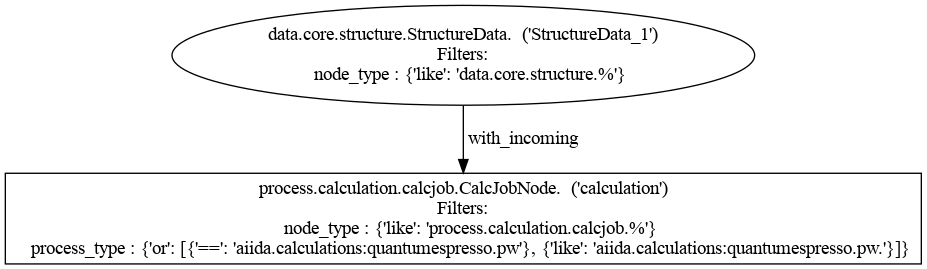

In [21]:
generate_query_graph(query.queryhelp, 'query1.png')
Image(filename='query1.png')

The `with_incoming` keyword is only one of many potential relationships that exist between the various AiiDA nodes and that are implemented in the `QueryBuilder`.
The table below gives an overview of the implemented relationships, which nodes they are defined for and what relation it implicates.
The full list of relations can be found {ref}`on this page of the AiiDA documentation<aiida:topics:database:advancedquery:tables:relationships>`.

Entity from | Entity to | Relationship     | Explanation
------------|-----------|------------------|------------
Node        | Node      | with_outgoing    | One node as input of another node
Node        | Node      | with_incoming    | One node as output of another node
Node        | Node      | with_descendants | One node as the ancestor of another node
Node        | Node      | with_ancestors   | One node as descendant of another node
Group       | Node      | with_node        | The group of a node
Node        | Group     | with_group       | The node is a member of a group
Computer    | Node      | with_node        | The computer of a node
Node        | Computer  | with_computer    | The node of a computer
User        | Node      | with_node        | The creator of a node is a user
Node        | User      | with_user        | The node was created by a user

### Exercise

See if you can write a query that will return all the `UpfData` nodes that are a member of a `Group` whose name ends with the string `_pbe`.

In [22]:
query = QueryBuilder()
# Visualize what is going on:
generate_query_graph(query.queryhelp, 'query2.png')
Image(filename='query2.png')

## Attributes and extras

In [the section above](query/project), you learned how you to `project` specific properties of a node and gave a list of properties that a node instance possesses.
Since then, we have come across different AiiDA data nodes, such as `StructureData` and `UpfData`.
As AiiDA employs the object-oriented programming paradigm, both `StructureData` and `UpfData` are examples of sub-classes of the `Node` class and therefore inherit its properties.
That means that whatever property a `Node` has, both `StructureData` and `UpfData` will have too.
However, there is a semantic difference between what `StructureData` and `UpfData` represent, and as such they have been explicitly defined as sub-classes to be able to add properties to one that would not make sense for the other.
This would normally create issues for the type of database AiiDA uses, but this is solved through the concept of `attributes`.
These are similar to properties, except that they are specific to the `Node` type that they are attached to.
This allows you to add an `attribute` to a certain node, without having to change the implementation of all the others.

For example, the `Dict` nodes that are generated as output of `PwCalculation`s may have an attribute named `wfc_cutoff`.
To project for this particular `attribute`, one can use exactly the same syntax as shown in [the section above](query/project) for the regular `Node` properties, and one has to only prepend `attributes.` to the attribute name.

Demonstration:

In [23]:
query = QueryBuilder()
query.append(PwCalculation, tag='pw')
query.append(Dict, with_incoming='pw', project=["attributes.wfc_cutoff"])
query.limit(5)
query.all()

[[816.341503518],
 [816.341503518],
 [816.341503518],
 [816.341503518],
 [816.341503518]]

Note that if any `Dict` node does not have this attribute, the `QueryBuilder` will return the Python keyword `None`.
Similar to the `attributes`, nodes can also have `extras`, which work in the same way as for `attributes`, except that `extras` are mutable, which means that their value can be changed even after a node instance has been stored.

If you are not sure which attributes a given node has, you can use the `attributes` `Node` class attribute to simply retrieve them all.
It will return a dictionary with all the attributes the node has.

Note that a node also has a number of additional methods and attributes.
For instance, you can do `node.base.attributes.keys()` to get only the attribute keys or `node.base.attributes.get('wfc_cutoff')` to get the value of a single attribute (these two variants are more efficient if the node has a lot of attributes and you don't need all data).
Similarly, for `extras`, you have `node.base.extras.all`, `node.base.extras.keys()`, and `node.base.attributes.get('<SOME_EXTRA_KEY>')`.

In [24]:
query = QueryBuilder()
query.append(PwCalculation)
node, = query.first()
print('Attributes dictionary:', node.base.attributes.all, '\n')
print('Extras dictionary:', node.base.extras.all)

Attributes dictionary: {'job_id': '462206', 'sealed': True, 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 8, 'default_mpiprocs_per_machine': 8}, 'exit_status': 0, 'parser_name': 'quantumespresso.basicpw', 'last_jobinfo': '{"job_id": "462206", "wallclock_time_seconds": 374, "title": "aiida-41078", "num_machines": 1, "job_state": "RUNNING", "queue_name": "normal", "num_mpiprocs": 8, "allocated_machines_raw": "nid00373", "submission_time": {"date": "2014-10-28T20:07:12.000000", "timezone": null}, "job_owner": "mounet", "detailedJobinfo": "Detailed jobinfo obtained with command \'sacct --format=AllocCPUS,Account,AssocID,AveCPU,AvePages,AveRSS,AveVMSize,Cluster,Comment,CPUTime,CPUTimeRAW,DerivedExitCode,Elapsed,Eligible,End,ExitCode,GID,Group,JobID,JobName,MaxRSS,MaxRSSNode,MaxRSSTask,MaxVMSize,MaxVMSizeNode,MaxVMSizeTask,MinCPU,MinCPUNode,MinCPUTask,NCPUS,NNodes,NodeList,NTasks,Priority,Partition,QOSRAW,ReqCPUS,Reserved,ResvCPU,ResvCPURAW,Start,State,Submit,Suspended,SystemC

The chemical element symbol of a pseudopotential represented by a `UpfData` node is stored in the `element` attribute.

### Exercise

Using the knowledge on how filtering on `attributes` works, see if you can write a query that will search your database for pseudopotentials for silicon.

In [25]:
query = QueryBuilder()

## Generating a provenance graph

Previously we have used `verdi graph generate` on the command-line, to generate a graph of the data provenance.
To do this, AiiDA uses some of the queries you have learned about above.
We can also visualise sections of the provenance in a more customisable way, using the `Graph` class.

For example, lets query for a calculation, then use methods of the `Graph` class to visualise the inputs and outputs of this calculation:

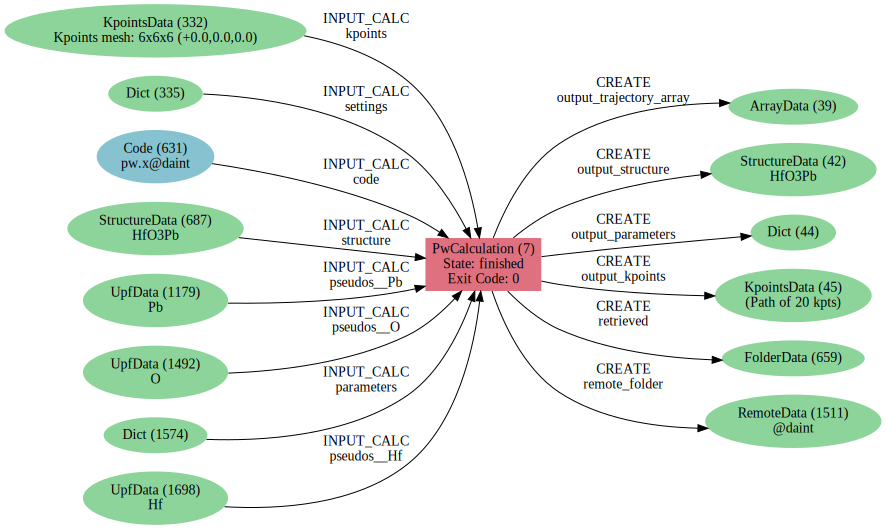

In [26]:
query = QueryBuilder()
query.append(PwCalculation)
node, = query.first()

from aiida.tools.visualization import Graph
graph = Graph(graph_attr={"rankdir": "LR"})

graph.add_incoming(node.uuid, annotate_links="both")
graph.add_outgoing(node.uuid, annotate_links="both")
graph.graphviz

The `Graph` class also has methods for recursing up or down the provenance tree.
In this example, let's query for a pseudopotential, and visualise which processes it is used in:

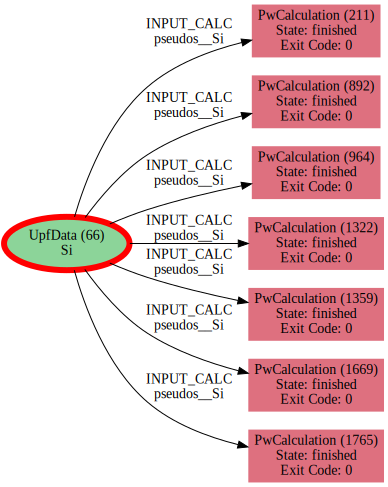

In [27]:
query = QueryBuilder()
query.append(UpfData, filters={'attributes.element': {'==': 'Si'}})
node, = query.first()

graph = Graph(graph_attr={"rankdir": "LR"})

graph.recurse_descendants(
    node.uuid,
    annotate_links="both",
    depth=1
)
graph.graphviz

For further information on using `Graph` to generate provenance graphs, please see [this section](https://aiida.readthedocs.io/projects/aiida-core/en/latest/howto/visualising_graphs.html) in the documentation.

## A small high-throughput study

````{important}
This section relies on a specific dataset of previously run calculations. If you have already imported the dataset from the "Organising your data" module, you should be good to go!

Alternatively, the dataset is included in the virtual machine image of the AiiDA tutorial from [aiida-tutorials.readthedocs.io](https://aiida-tutorials.readthedocs.io) (choose the correct version of the tutorial, depending on which version of AiiDA you want to try).

If the data is not available yet, you can use the following command to import the required calculations (if you are in a notebook you can execute the command in a cell by adding an exclamation mark `!` in front)::

```{code-block} console
verdi archive import https://object.cscs.ch/v1/AUTH_b1d80408b3d340db9f03d373bbde5c1e/marvel-vms/tutorials/aiida_tutorial_2022_10_perovskites_main_0001.aiida
```

````

In this part of the tutorial, we will focus on how to systematically retrieve, parse and analyze the results of multiple calculations using AiiDA.
While you may be able to do this on your own, to save time a set of calculations have already been done with AiiDA for you on 57 perovskites, using three different pseudopotential families (LDA, PBE and PBESOL, all from GBRV 1.2).

These calculations are spin-polarized (without spin-orbit coupling), use a Gaussian smearing and perform a variable-cell relaxation of the full unit cell.
The goal of this part of the tutorial is to have you utilize what you have learnt in the previous sections and “screen” for magnetic and metallic perovskites in a “high-throughput” way.
As you learned previously in the tutorial, AiiDA allows to organize calculations into groups.
Once more check the list of groups in your database by typing (From jupyter notebook or `IPython`):

In [28]:
!verdi group list -a -A

  PK  Label            Type string    User
----  ---------------  -------------  ----------------------
   1  tutorial_pbesol  core           aiida@localhost
   2  tutorial_lda     core           aiida@localhost
   3  tutorial_pbe     core           aiida@localhost
   4  GBRV_lda         core.upf       aiida@localhost
   5  GBRV_pbe         core.upf       aiida@localhost
   6  GBRV_pbesol      core.upf       aiida@localhost
   7  20220829-115825  core.import    kristjan.eimre@epfl.ch


The calculations needed for this task were put into three different groups whose labels start with `'tutorial'` (one for each pseudopotential family).
The main task is to make a plot showing, for all perovskites and for each pseudopotential family, the total magnetization and the $-TS$ contribution from the smearing to the total energy.

### Start building the query

First you should instantiate a `QueryBuilder` instance.
To this, you can `append` the groups of interest, which means that you should select only groups that start with the string `tutorial_`.
The query can be executed after this `append` (this will not affect the final results) to check whether 3 groups are retrieved.

Groups: tutorial_lda, tutorial_pbe, tutorial_pbesol


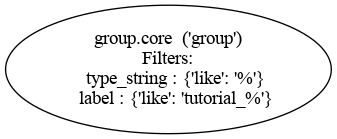

In [29]:
query = QueryBuilder()
query.append(
    Group,
    filters={
        'label': {'like': 'tutorial_%'}
    },
    project='label',
    tag='group'
)
# Visualize:
print("Groups:", ', '.join([g for g, in query.all()]))
generate_query_graph(query.queryhelp, 'query3.png')
Image(filename='query3.png')

:::{important}

Most of the code cells below are incomplete, and need to be completed as an exercise.
Look for the comments for more instructions.

:::

### Append the calculations that are members of each group

Try to complete the incomplete lines below:

In [30]:
# Retrieve every PwCalculation that is a member of the specified groups:
query.append(PwCalculation, tag='calculation', with_group=) # Complete the function call with the correct relationship-tag!
# Visualize:
generate_query_graph(query.queryhelp, 'query4.png')
Image(filename='query4.png')

SyntaxError: invalid syntax (1798323979.py, line 2)

### Append the structures that are inputs to the calculation

We want to furthermore retrieve the crystal structures used as inputs for the calculations.
This can be done by an `append` `StructureData`, and defining the relationship with the calculations with an appropriate relationship keyword, in this case `with_outgoing`.

For simplicity the formulas have been added in the `extras` of each crystal structure node under the key `formula`.
(The function that does this is called `store_formula_in_extra` and can be found in the first cell of this notebook.)

Try to finish the code block below to project the formula, stored in the `extras` under the key `formula`.

In [31]:
query.append(StructureData, project=, tag='structure', with_outgoing=) # Complete the function call with the correct relationship-tag!
# Visualize:
generate_query_graph(query.queryhelp, 'query5.png')
Image(filename='query5.png')

SyntaxError: invalid syntax (2657099595.py, line 1)

### Append the output of the calculation

Every successful `PwCalculation` outputs a `Dict` node called `output_parameters` that stores the parsed results as key/value-pairs.
You can find these pairs among the attributes of the `Dict` node.
To facilitate querying, the parser takes care of always storing the values in the same units.
For convenience, the units are also added as key/value-pairs (with the same key name, but with `_units` appended).
Extend the query so that also the output `Dict` of each calculation is returned.
Project only the attributes relevant to your analysis.

In particular, project (in this order):

* The smearing contribution;
* The units of the smearing contribution;
* The magnetization; and
* The units of the magnetization.

(To know the projection keys, you can try to load one `CalcJobNode` from one of the groups, get its `output_parameters` node and inspect its `attributes` as discussed before, to see the key/value-pairs that have been parsed.)

In [32]:
query.append(Dict, tag='results', project=['attributes.energy_smearing', ...], with_incoming=) # Complete the function call!
# Visualize:
generate_query_graph(query.queryhelp, 'query6.png')
Image(filename='query6.png')

SyntaxError: invalid syntax (4128581425.py, line 1)

### Print the query results

You can print the results to see if everything worked as expected.

In [33]:
results = query.all()
for item in results:
    print(', '.join(map(str, item)))

tutorial_lda
tutorial_pbe
tutorial_pbesol


### Plot the results

Getting a long list is not always helpful, and a graph can be much more clear and useful.
To help you, we have already prepared a function that visualizes the results of the query.
Run the following cell and you should get a graph with the results of your queries.

In [34]:
plot_results(results)

ValueError: not enough values to unpack (expected 6, got 1)